In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evallm
from automata.fa.dfa import DFA
import tqdm.auto as tqdm

import textwrap

In [3]:
import itertools
from permacache import stable_hash

In [4]:
import io


from evallm.experiments.transducer_plotting import produce_table

from evallm.experiments.transducer_summary import prompt_by_key as prompts_t
from evallm.experiments.sequence_completion_summary import (
    prompts_by_key as prompts_s,
    current_setting as current_setting_s,
)

from evallm.experiments.exhaustive_transducer_experiment import (
    run_experiment_for_dfa,
    SummaryStats,
    compute_ngram_each,
)
from evallm.enumerate_dfa.pack_dfa import pack_dfa, unpack_dfa
from evallm.experiments.sequence_completion.sequence_completion_experiments import (
    run_model as run_model_sc,
    score_model_responses as score_model_responses_sc,
    collate_model_responses as collate_model_responses_sc,
)
from evallm.experiments.sequence_completion.sample_sequences import (
    sample_task_instances_given_dfa,
)
from evallm.experiments.sequence_completion.ngram_suffix_heuristic import (
    multiple_ngrams,
)
from evallm.experiments.example import (
    transducer_example_csv,
    plot_errors,
    generate_data_for_dfa,
    qualitative_results_table,
)

# from evallm.prompting.transducer_prompt import BasicSequencePrompt, BasicSequencePromptNoChat

In [5]:
# chat_prompt = prompt_by_key["Basic"]["chat"]
# non_chat_prompt = prompt_by_key["Basic"]["non-chat"]

In [6]:
sum_dfa, sequence_tasks = generate_data_for_dfa(
    lambda a, b: (a + b) % 3, current_setting_s
)

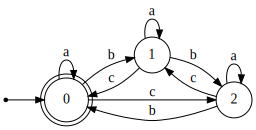

In [7]:
sum_dfa

In [8]:
res_claude_t = run_experiment_for_dfa(
    prompts_t["Red-Green"]["chat"],
    pack_dfa(sum_dfa),
    1000,
    "claude-3-5-sonnet-20241022",
    0,
    keep_completions=True,
)

In [9]:
res_qwen_t = run_experiment_for_dfa(
    prompts_t["Basic"]["non-chat"],
    pack_dfa(sum_dfa),
    1000,
    "Qwen/Qwen2.5-Coder-7B-Instruct",
    0,
)

In [10]:
from matplotlib_venn import venn3

In [11]:
transducer_masks = {
    "CR": res_claude_t.accuracy_each,
    "QB": res_qwen_t.accuracy_each,
    "6gram": compute_ngram_each(res_qwen_t)[:, 6 - 2],
}

In [12]:
transducer_trivial_cases = (res_claude_t.inputs_packed[:, -1] == 0) | (
    res_claude_t.outputs_packed[:, -2] == 1
)

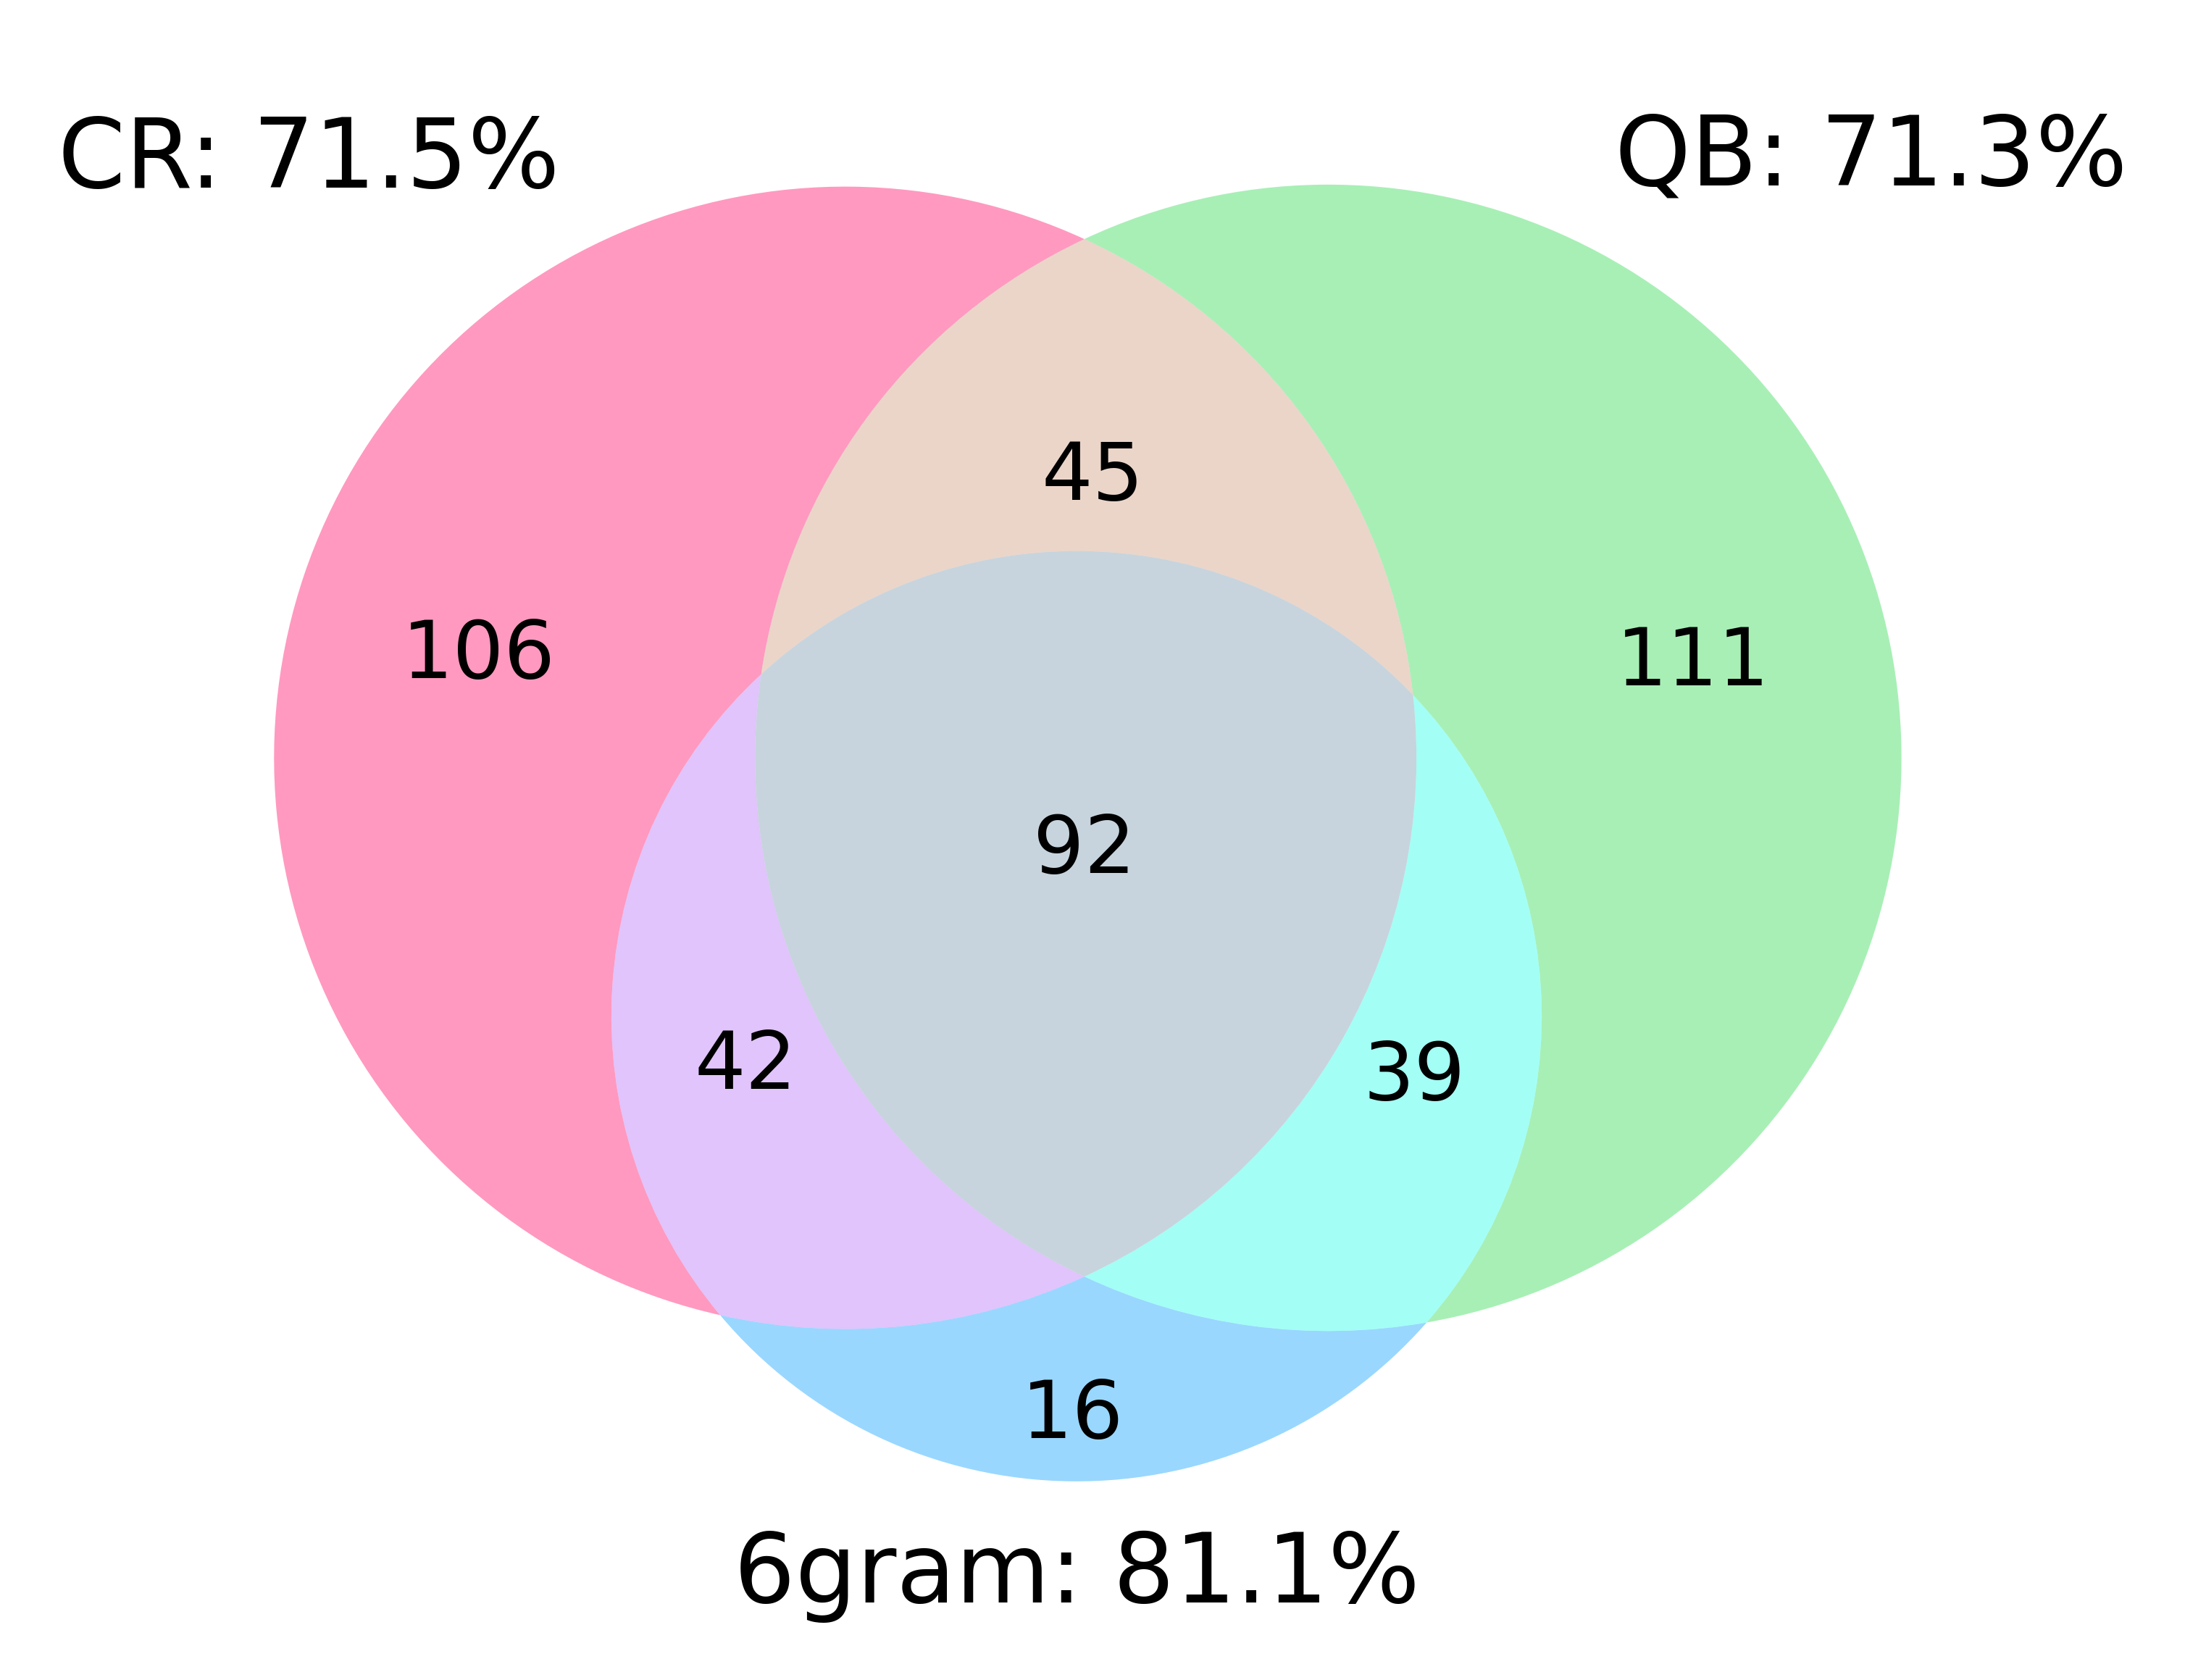

In [13]:
plt.figure(tight_layout=True, dpi=800, figsize=(4.5, 3))
plot_errors(transducer_masks)
plt.savefig("../output/example_dfa/sum_dfa_transducer_error.png", dpi=800)

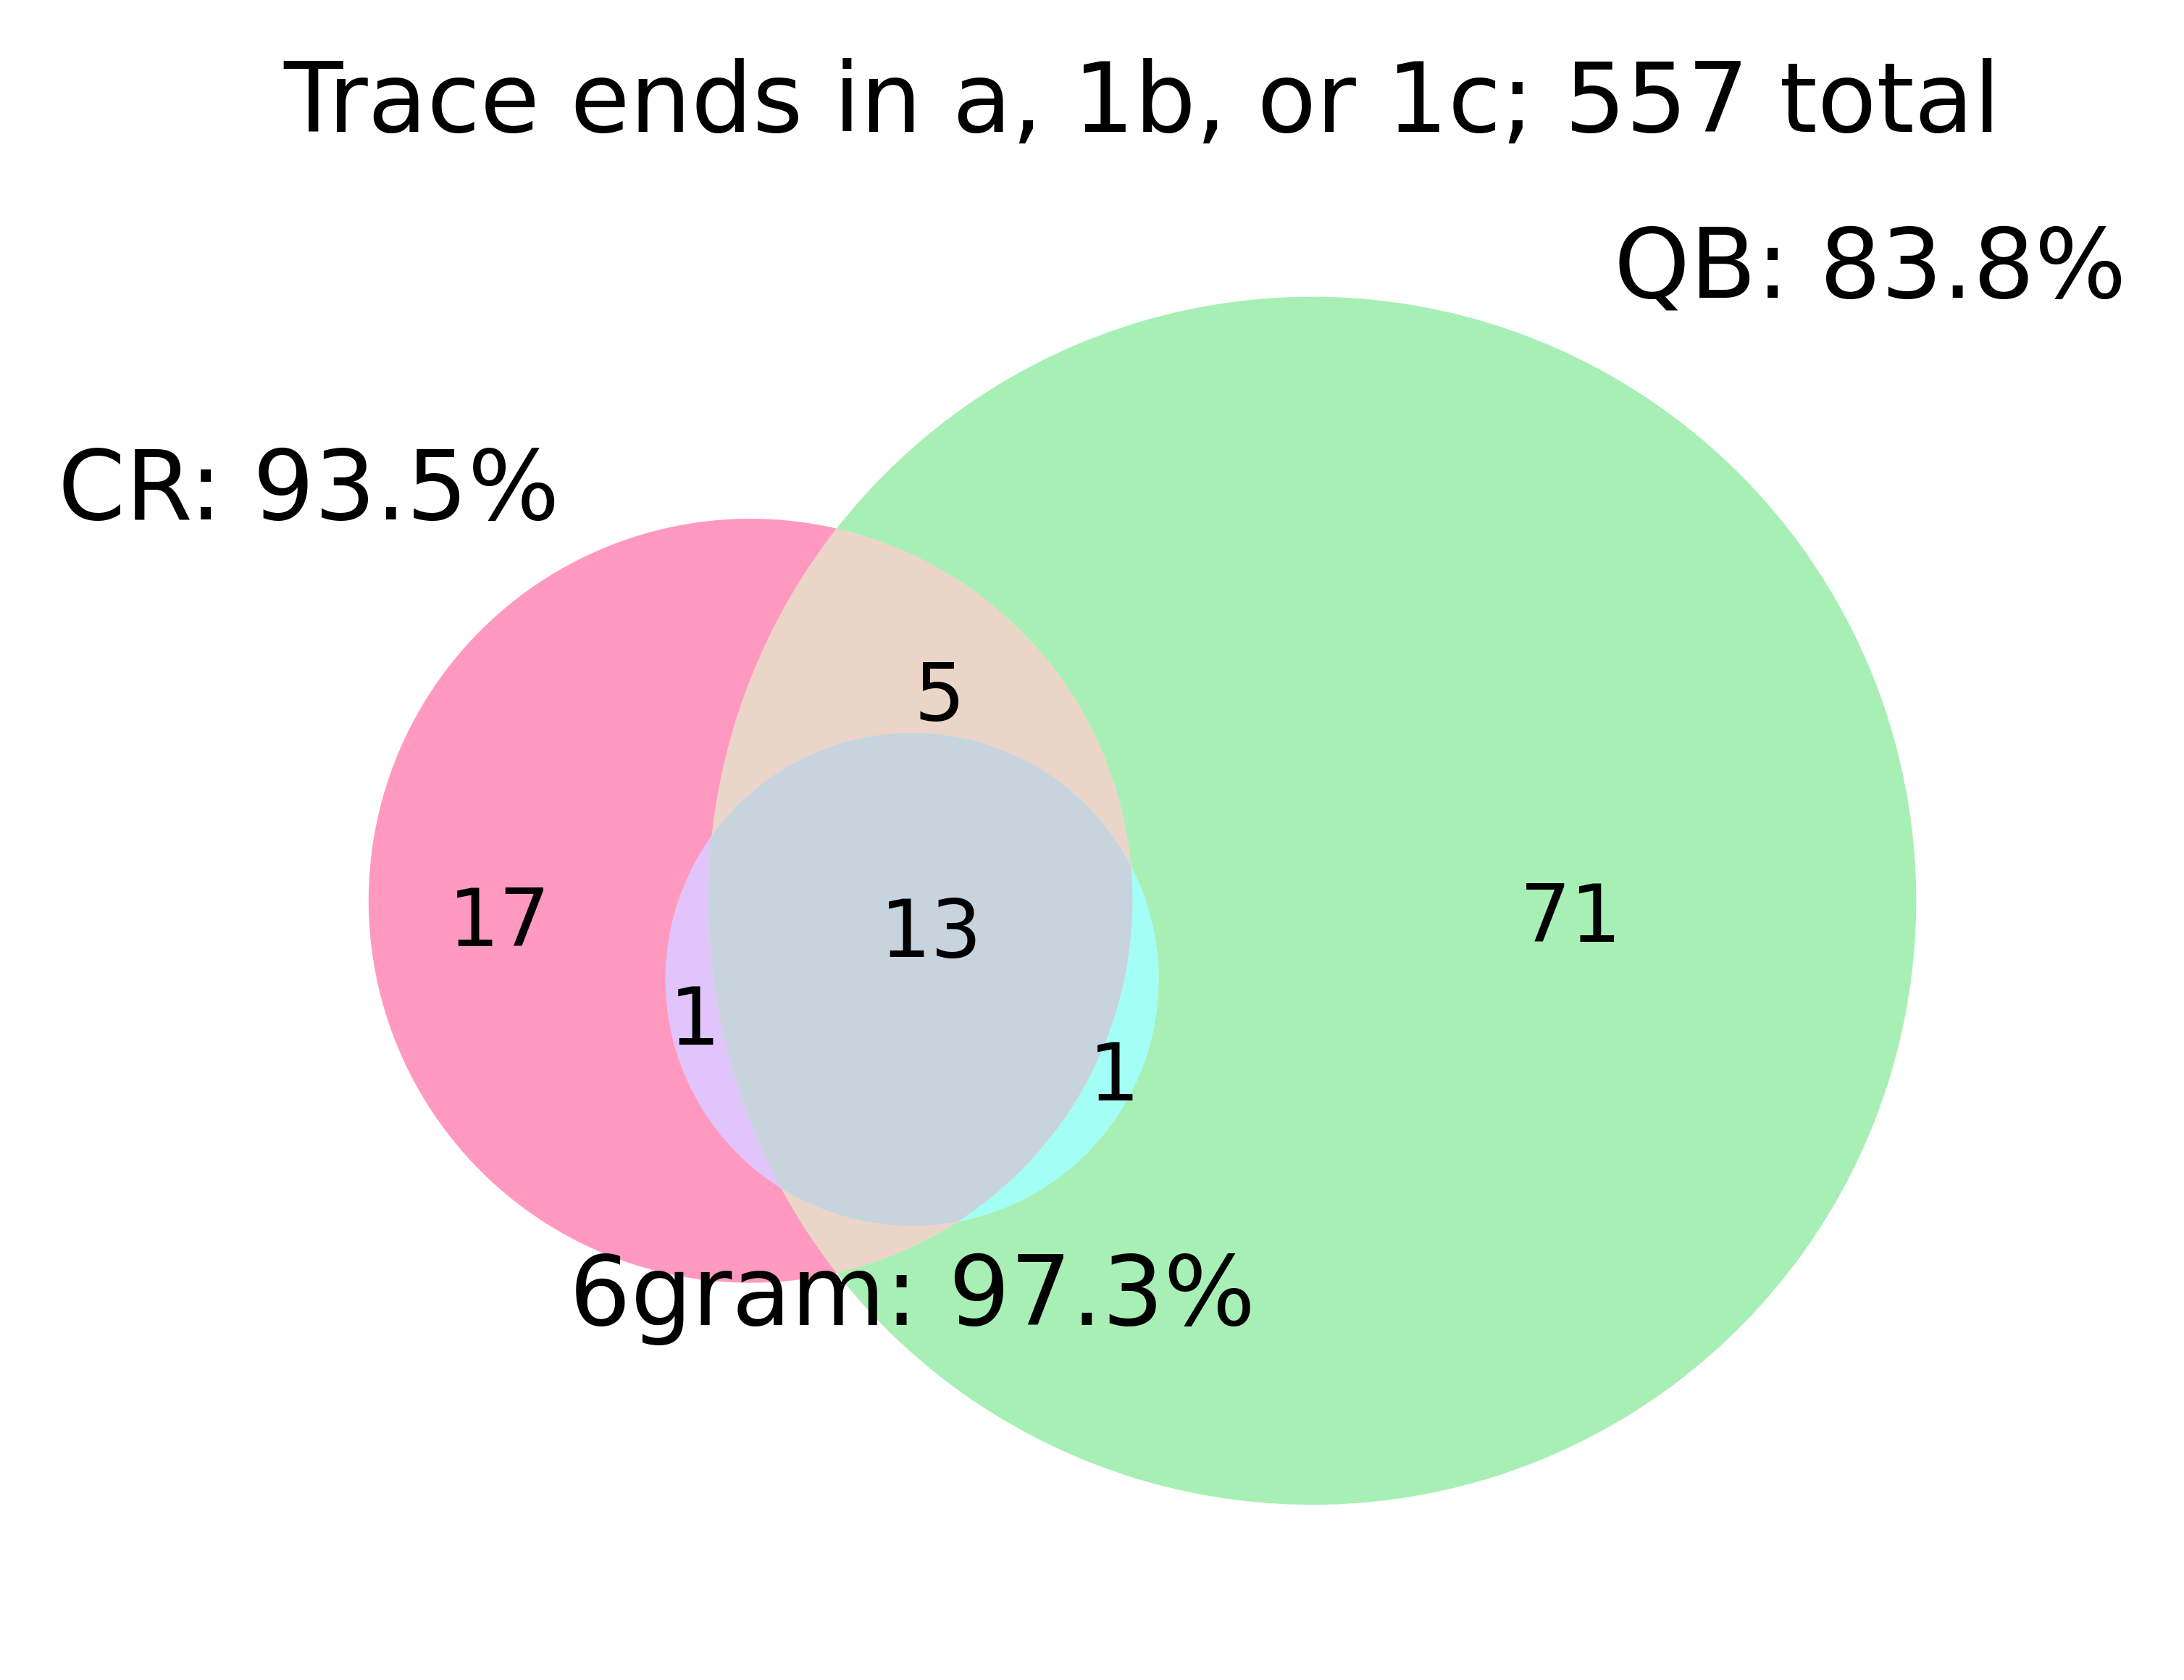

In [14]:
plt.figure(tight_layout=True, dpi=800, figsize=(4.5, 3))
plot_errors({k: v[transducer_trivial_cases] for k, v in transducer_masks.items()})
plt.title(f"Trace ends in a, 1b, or 1c; {transducer_trivial_cases.sum()} total")
plt.savefig("../output/example_dfa/sum_dfa_transducer_error_trivial.png", dpi=800)

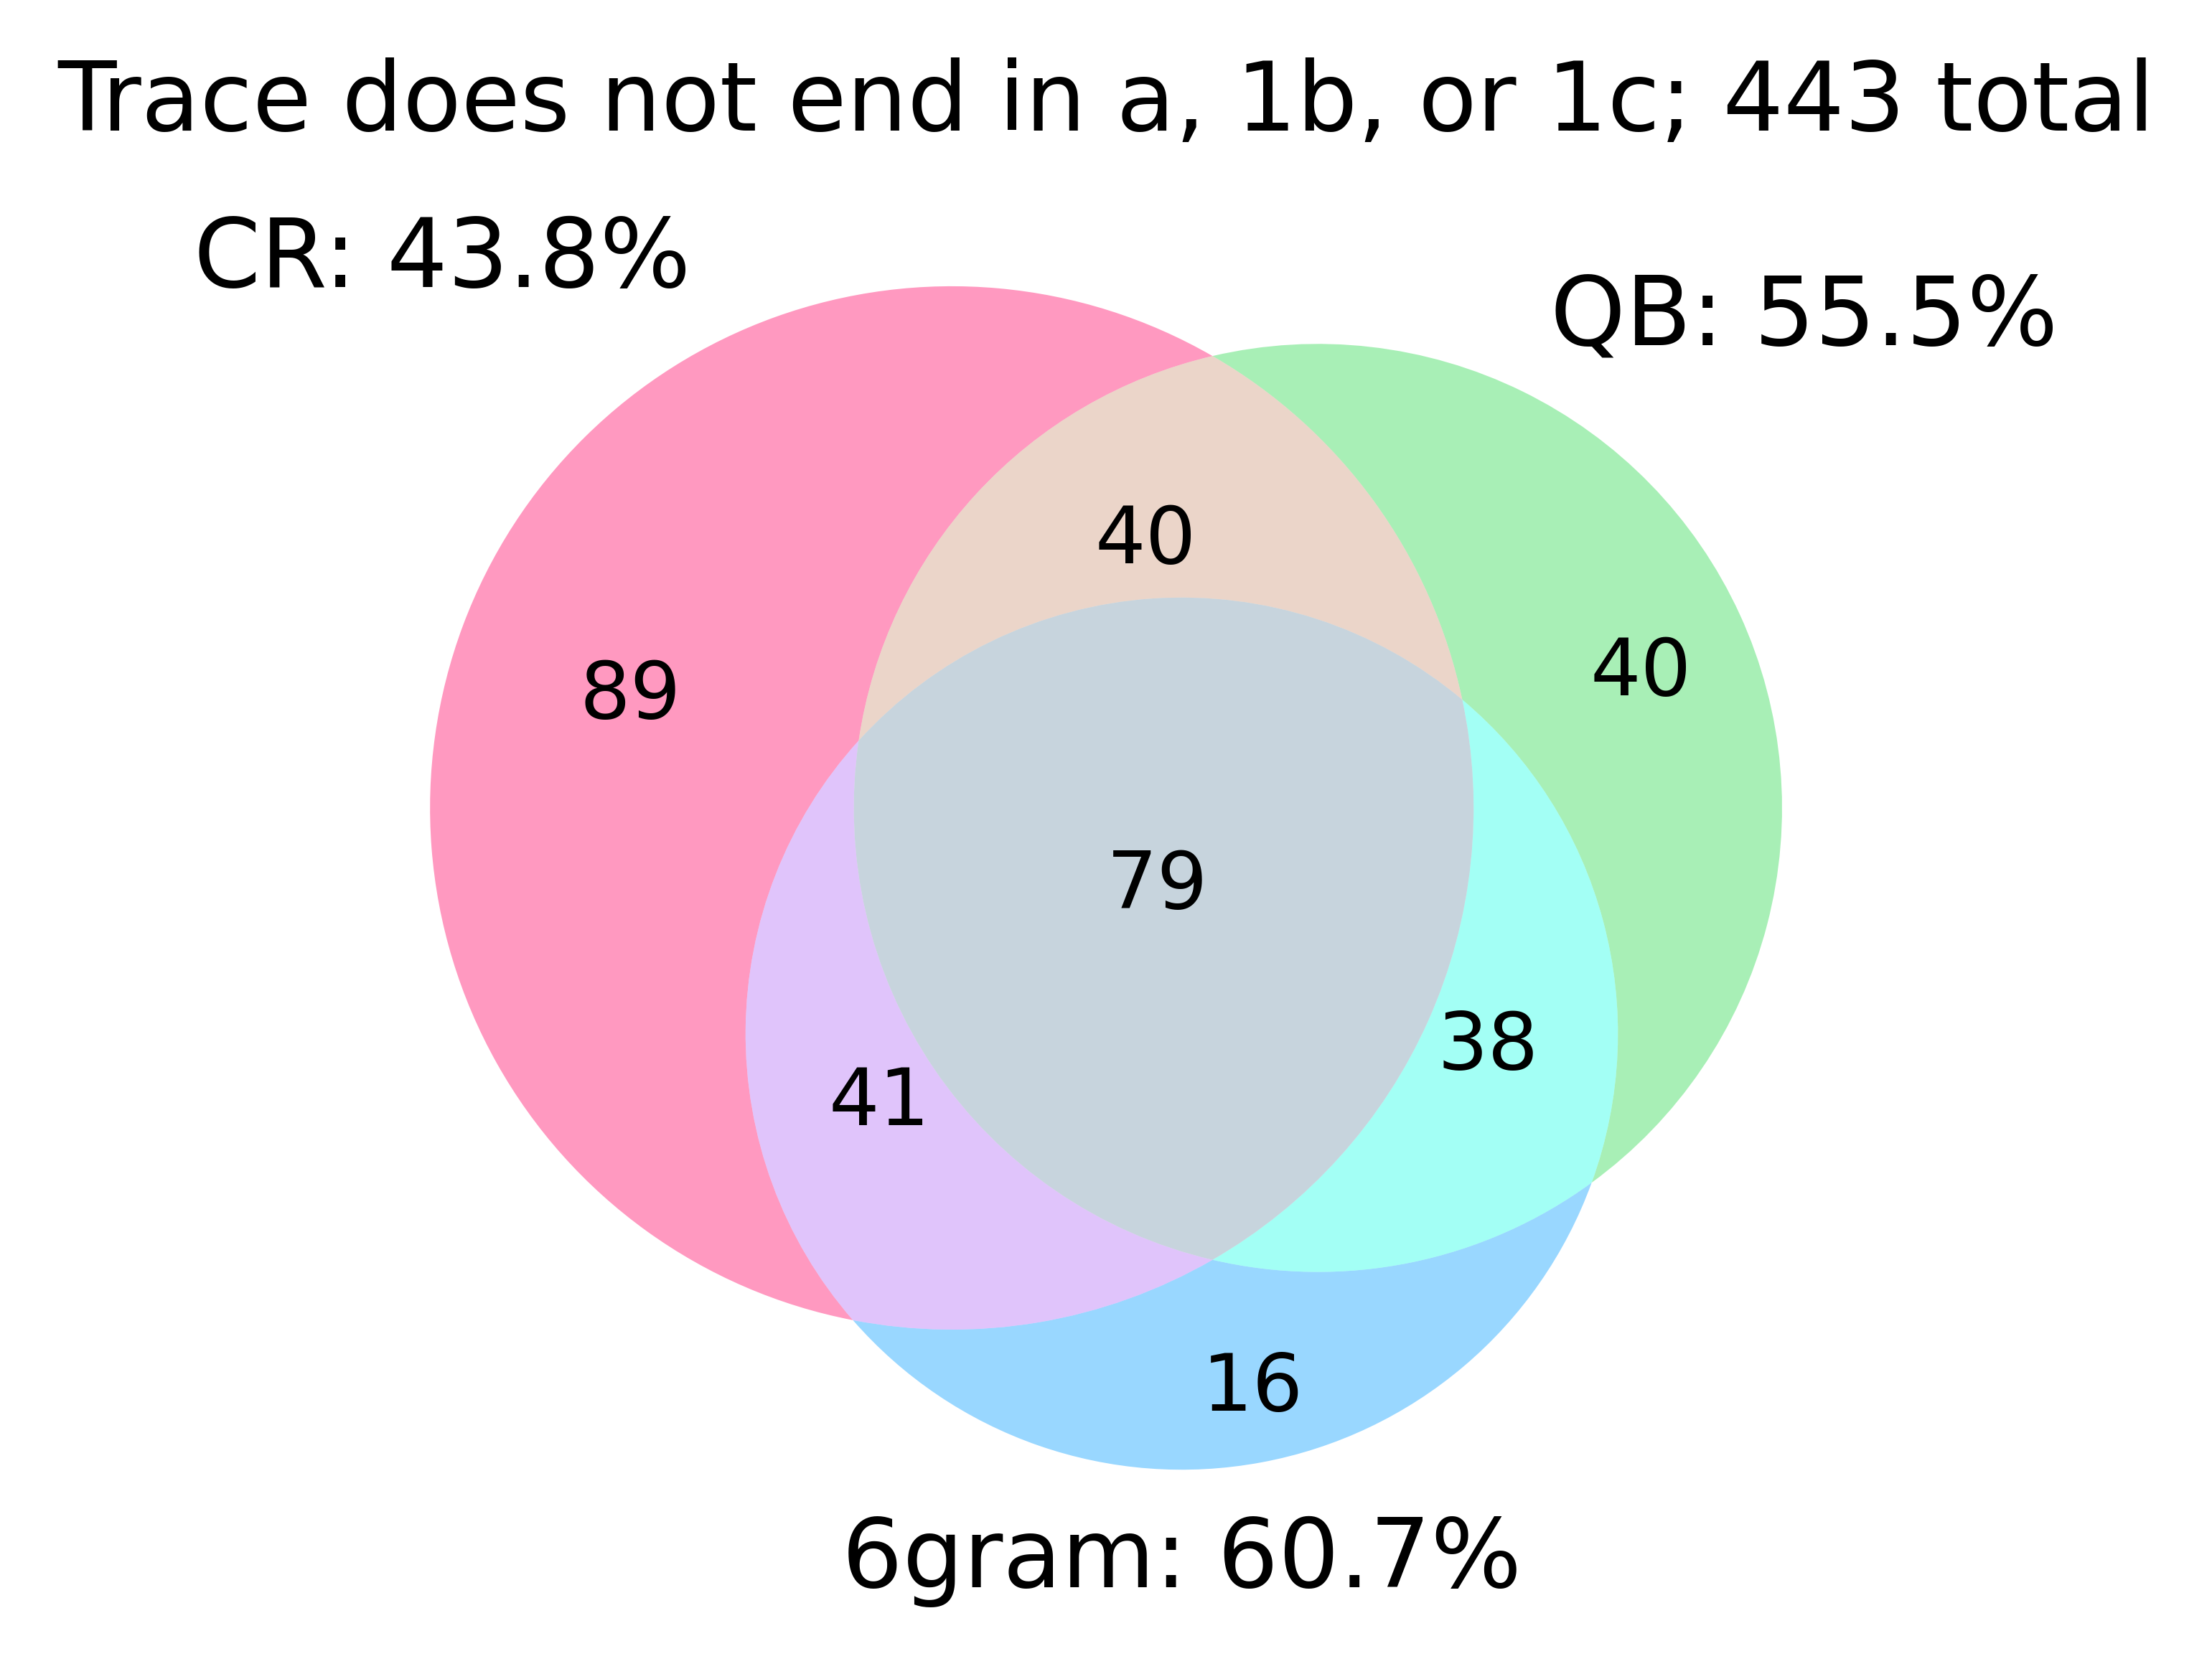

In [15]:
plt.figure(tight_layout=True, dpi=800, figsize=(4.5, 3))
plot_errors({k: v[~transducer_trivial_cases] for k, v in transducer_masks.items()})
plt.title(
    f"Trace does not end in a, 1b, or 1c; {(~transducer_trivial_cases).sum()} total"
)
plt.savefig("../output/example_dfa/sum_dfa_transducer_error_nontrivial.png", dpi=800)

In [16]:
def random_samples_each(masks, size=30):
    rng = np.random.RandomState(0)
    return {k: rng.choice(np.where(masks[k])[0], size=size) for k in masks}

In [17]:
masks_t = {
    "claude-correct": transducer_masks["CR"] == 1,
    "claude-incorrect-6gram-correct": (transducer_masks["CR"] == 0)
    & (transducer_masks["6gram"] == 1),
}
samples_t = random_samples_each(masks_t)

In [18]:
! mkdir -p ../output/example_dfa

In [19]:
claude_reasoning_traces = [x.message.content.lower() for x in res_claude_t.completions]
[x for x in claude_reasoning_traces if "sum" in x or "mod" in x]

["let me analyze the pattern in your movements:\n\ni notice a repeating sequence early on:\nb->red, a->red, c->green\n\nthis sequence repeats exactly 4 times at the start, suggesting you were cycling through the same rooms using the same portals.\n\nlater, there are sequences like:\na->green, a->green showing that some room has an a portal that leads to itself (assuming it's a green room)\n\nlooking at the final sequence:\nb->red, b->red, a->red, a->???\n\nsince we see b->red twice in a row, we must be in a room where portal b leads to itself (in a red room). then taking portal a from that red room leads to another red room. taking a again from that red room should follow the same pattern we've seen before.\n\nbased on the patterns observed, when you take portal a from this red room, you should end up in a red room again.\n\n<answer>red</answer>"]

In [20]:
transducer_example_csv(res_claude_t, samples_t).to_csv(
    "../output/example_dfa/transducer_claude_sample.csv"
)

In [21]:
# Output taken from Qualitative Analysis notebook
qualitatives = r"""
	Total	\texttt{a} is no-op	\texttt{1b} and \texttt{1c} lead to 0	2 red rooms	2-periodic	3-periodic	$>3$-\textsc{Gram}	Sum Modulo 3	\texttt{b} and \texttt{c} cancel
Correct	30	21	14	2	9	4	4	0	0
Incorrect	30	22	17	3	14	4	5	0	1
"""
qualitatives = pd.read_csv(io.StringIO(qualitatives), sep="\t").T
qualitatives.columns = qualitatives.iloc[0]
qualitatives = qualitatives[1:]
qualitatives = qualitatives.reset_index()
qualitatives.columns = ["", *qualitatives.columns[1:]]

In [22]:
qualitatives

,,Correct,Incorrect
0,Total,30,30
1,\texttt{a} is no-op,21,22
2,\texttt{1b} and \texttt{1c} lead to 0,14,17
3,2 red rooms,2,3
4,2-periodic,9,14
5,3-periodic,4,4
6,$>3$-\textsc{Gram},4,5
7,Sum Modulo 3,0,0
8,\texttt{b} and \texttt{c} cancel,0,1


In [23]:
def figure_minipage(name, path):
    return textwrap.dedent(
        r"""
    \begin{minipage}[t]{0.1\linewidth}
    {\Large ($1)}
    \end{minipage}
    \begin{minipage}{0.8\linewidth}
    \includegraphics[width=\linewidth]{figures/$2}
    \end{minipage}\\
    """.replace(
            "$1", name
        ).replace(
            "$2", path
        )
    )

In [24]:
figure = ""
figure += figure_minipage("a", "sum_dfa_transducer_error.png")
figure += r"""
\begin{minipage}[t]{0.1\linewidth}
{\Large (b)}
\end{minipage}
\begin{minipage}{0.8\linewidth}
"""
figure += qualitative_results_table(qualitatives)
figure += "\end{minipage}"

In [25]:
print(figure)


\begin{minipage}[t]{0.1\linewidth}
{\Large (a)}
\end{minipage}
\begin{minipage}{0.8\linewidth}
\includegraphics[width=\linewidth]{figures/sum_dfa_transducer_error.png}
\end{minipage}\\

\begin{minipage}[t]{0.1\linewidth}
{\Large (b)}
\end{minipage}
\begin{minipage}{0.8\linewidth}
\begin{tabular}{|r|r|r|}
\hline
 & Correct & Incorrect \\\hline
Total & 30 & 30 \\
\hline
\texttt{a} is no-op & 21 & 22 \\
\hline
\texttt{1b} and \texttt{1c} lead to 0 & 14 & 17 \\
\hline
2 red rooms & 2 & 3 \\
\hline
2-periodic & 9 & 14 \\
\hline
3-periodic & 4 & 4 \\
\hline
$>3$-\textsc{Gram} & 4 & 5 \\
\hline
Sum Modulo 3 & 0 & 0 \\
\hline
\texttt{b} and \texttt{c} cancel & 0 & 1 \\
\hline
\end{tabular}
\end{minipage}


In [26]:
print(figure_minipage("a", "sum_dfa_transducer_error_trivial.png"))
print(figure_minipage("b", "sum_dfa_transducer_error_nontrivial.png"))


\begin{minipage}[t]{0.1\linewidth}
{\Large (a)}
\end{minipage}
\begin{minipage}{0.8\linewidth}
\includegraphics[width=\linewidth]{figures/sum_dfa_transducer_error_trivial.png}
\end{minipage}\\


\begin{minipage}[t]{0.1\linewidth}
{\Large (b)}
\end{minipage}
\begin{minipage}{0.8\linewidth}
\includegraphics[width=\linewidth]{figures/sum_dfa_transducer_error_nontrivial.png}
\end{minipage}\\



In [27]:
# sumprime_dfa, sumprime_sequence_tasks = generate_data_for_dfa(
#     lambda a, b: (a + b) % 2 if a != 2 and b != 2 else 2 if a != 2 else 1,
#     current_setting_s,
# )

In [28]:
# sumprime_dfa|

In [29]:
# sc_qwen = run_model_sc(
#     "Qwen/Qwen2.5-Coder-7B",
#     prompts_s["Basic"](current_setting_s),
#     sumprime_dfa,
#     sumprime_sequence_tasks[:460],
# )

In [30]:
# sc_claude = run_model_sc(
#     "claude-3-5-sonnet-20241022",
#     prompts_s["COT"](current_setting_s),
#     sumprime_dfa,
#     sumprime_sequence_tasks[:460],
# )

In [31]:
# sc_claude_rg = run_model_sc(
#     "claude-3-5-sonnet-20241022",
#     prompts_s["Red-Green"](current_setting_s),
#     sumprime_dfa,
#     sumprime_sequence_tasks,
# )

In [32]:
# def sixgram(dfa, sequence_tasks):
#     return np.array(
#         [
#             dfa.accepts_input(prefix + multiple_ngrams(sequences, prefix)[6 - 2])
#             for sequences, prefix in sequence_tasks
#         ]
#     )

In [33]:
# sequence_completion_masks = {
#     "qwen": np.array(
#         score_model_responses_sc(
#             prompts_s["Basic"](current_setting_s),
#             sumprime_dfa,
#             sumprime_sequence_tasks,
#             sc_qwen,
#         )
#     ),
#     "claude": np.array(
#         score_model_responses_sc(
#             prompts_s["COT"](current_setting_s),
#             sumprime_dfa,
#             sumprime_sequence_tasks,
#             sc_claude,
#         )
#     ),
#     "6gram": sixgram(sumprime_dfa, sumprime_sequence_tasks),
# }

In [34]:
# {k: v.mean() for k, v in sequence_completion_masks.items()}

In [35]:
# plot_errors(sequence_completion_masks)